# Predicting Solar Panel Energy Output with Machine Learning in Python

With the decline of fossil fuels, renewable energy is rapidly gaining promenince and the clean tech industry is skyrocketing. One such clean tech product, the solar panel, has a compounded annual growth rate of over 18%, marking an important shift to more sustainable technologies. However, even with such remarkable demand, it is often difficult to distinguish which factors affect the energy capacity of photovoltaic cells and the extent to which they are involved in determining energy output. Furthermore, measuring solar irradiance, the main influence on solar energy output, is often steeply priced and such data may not always be available, thereby highligting a significant obstacle to increase effective solar eneergy generation.

As a result, accurately predicting and identifying critical factors for solar power output is vital to sustain the rapid growth of solar energy in the future. In this project, 17 potential predictor variables will be analyzed from a publically available Kaggle dataset with data across 14 months and in 12 different locations, adding to the predictive power of the machine learning model. After cleaning and processing the data, feature engineering will be utilized for transforming and manipulating variables to better suit the machine learning model. Next, an extreme gradient boosting machine learning model through Python's XGBoost library will be trained on the data and then hyperparameter tuning will be implemented for additional model optimization. Finally, R-squared and Shapley value metrics will be assessed to measure the model's predictive accuracy for determining solar panel energy output.

In [20]:
# imports machine learning libraries and functions
from xgboost import XGBRegressor
from xgboost import plot_importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import feature_selection
from sklearn.model_selection import RandomizedSearchCV
import shap

In [21]:
# get data from csv, load into dataframe, show first 5 entries
df = pd.read_csv('solarPanelDataset.csv', index_col=False)
print(df.head())

      Location      Date  Time  Latitude  Longitude  Altitude    YRMODAHRMI  \
0  Camp Murray  20171203  1145     47.11    -122.57        84  2.017120e+11   
1  Camp Murray  20171203  1315     47.11    -122.57        84  2.017120e+11   
2  Camp Murray  20171203  1330     47.11    -122.57        84  2.017120e+11   
3  Camp Murray  20171204  1230     47.11    -122.57        84  2.017120e+11   
4  Camp Murray  20171204  1415     47.11    -122.57        84  2.017120e+11   

   Month  Hour  Season  Humidity  AmbientTemp  PolyPwr  Wind.Speed  \
0     12    11  Winter  81.71997     12.86919  2.42769           5   
1     12    13  Winter  96.64917      9.66415  2.46273           0   
2     12    13  Winter  93.61572     15.44983  4.46836           5   
3     12    12  Winter  77.21558     10.36659  1.65364           5   
4     12    14  Winter  54.80347     16.85471  6.57939           3   

   Visibility  Pressure  Cloud.Ceiling  
0        10.0    1010.6            722  
1        10.0    1011.

In [22]:
# shows details of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       21045 non-null  object 
 1   Date           21045 non-null  int64  
 2   Time           21045 non-null  int64  
 3   Latitude       21045 non-null  float64
 4   Longitude      21045 non-null  float64
 5   Altitude       21045 non-null  int64  
 6   YRMODAHRMI     21045 non-null  float64
 7   Month          21045 non-null  int64  
 8   Hour           21045 non-null  int64  
 9   Season         21045 non-null  object 
 10  Humidity       21045 non-null  float64
 11  AmbientTemp    21045 non-null  float64
 12  PolyPwr        21045 non-null  float64
 13  Wind.Speed     21045 non-null  int64  
 14  Visibility     21045 non-null  float64
 15  Pressure       21045 non-null  float64
 16  Cloud.Ceiling  21045 non-null  int64  
dtypes: float64(8), int64(7), object(2)
memory usage: 2

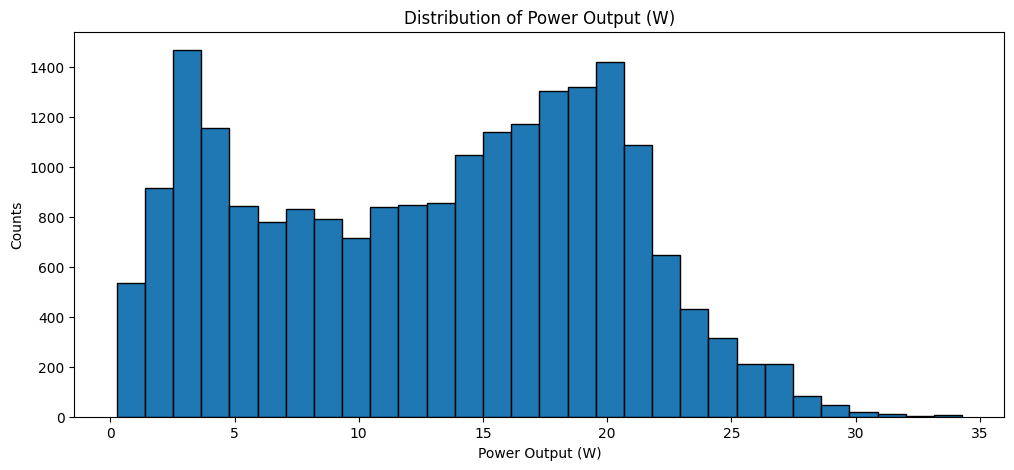

In [23]:
# plotting the distribution of power output
plt.figure(figsize=(12, 5))
plt.hist(df.PolyPwr, bins = 30, histtype='bar', ec='black')
plt.xlabel('Power Output (W)')
plt.ylabel('Counts')
plt.title('Distribution of Power Output (W)')
plt.show()

<Axes: >

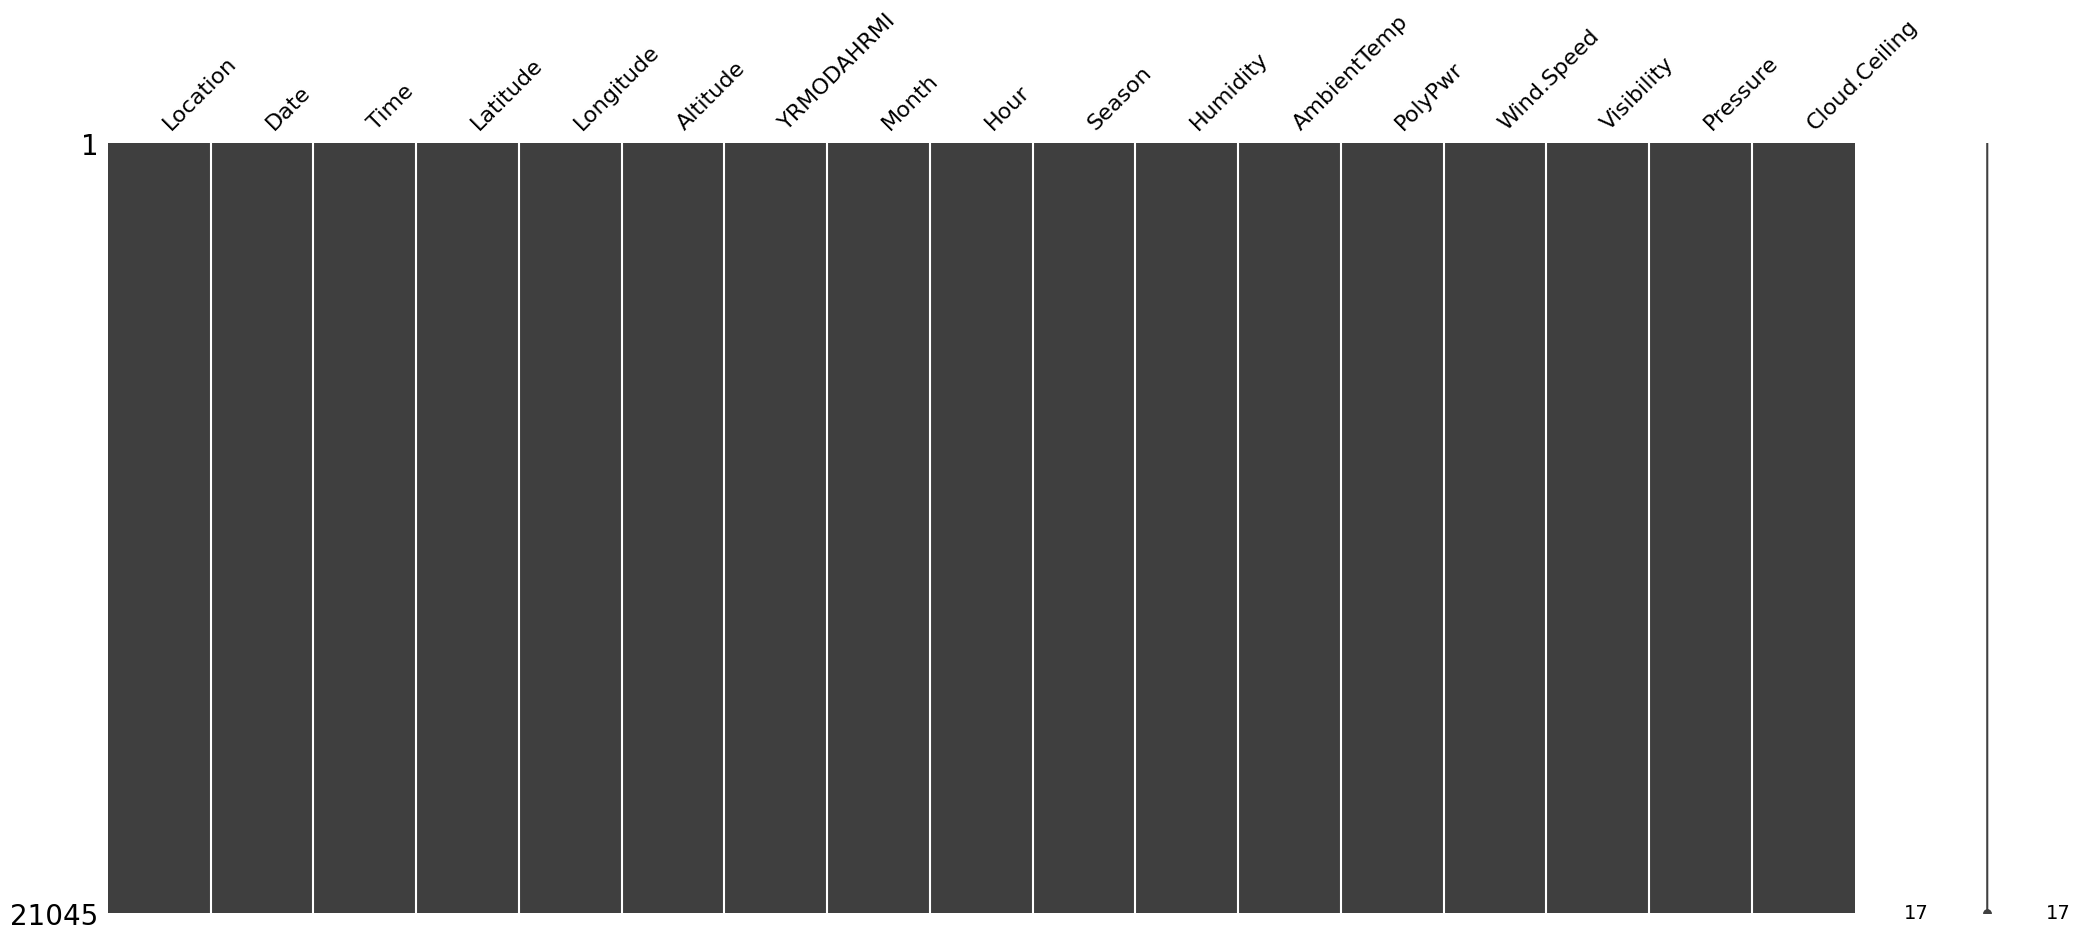

In [24]:
# checks to see how many "empty cells" there are in this dataset 
# (graph illustrates none)
msno.matrix(df)

In [25]:
# setup for correlation heatmap
df_temp = df[['Date', 'Location', 'Time', 'Latitude', 'Longitude', 'Altitude',
              'YRMODAHRMI', 'Month', 'Hour', 'Season', 'Humidity', 'AmbientTemp',
              'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling', 'PolyPwr']]

df_temp = df_temp.corr(method='pearson', numeric_only = True)


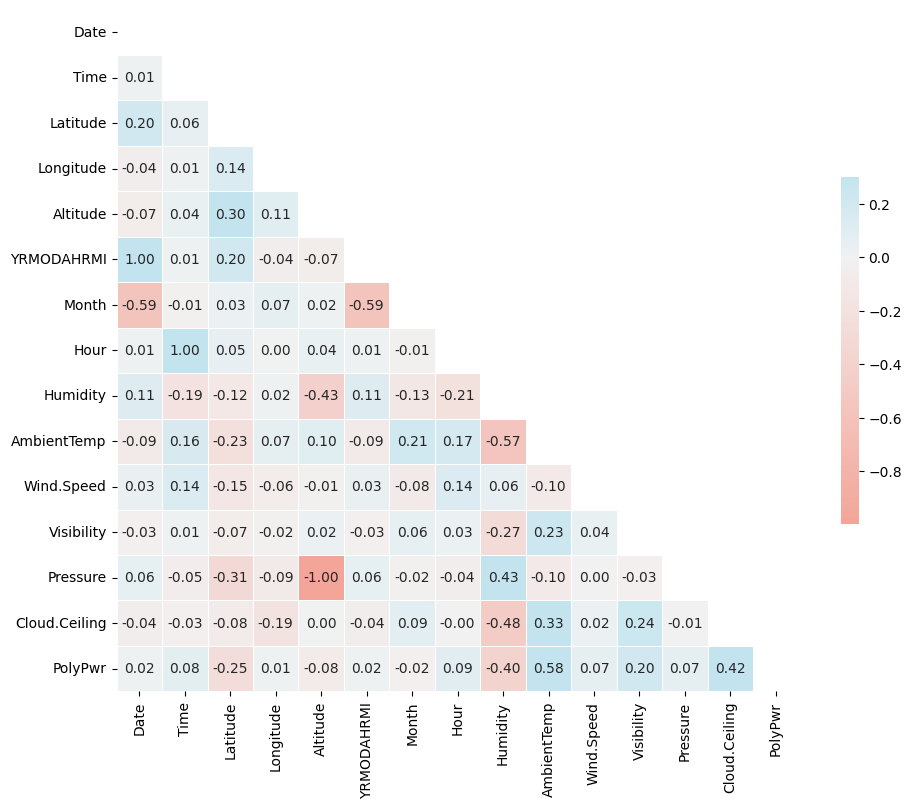

In [26]:
mask = np.triu(np.ones_like(df_temp, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(20, 220, s = 80, l = 75, as_cmap=True)

# Draw correlation heatmap
sns.heatmap(df_temp, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={'shrink': .5})

plt.show()

In [27]:
# feature engineered model based on dropping irrelevant variables or variables that may conflict with other variables in the model
independentVarsDf = df.drop(labels=(['Location', 'Season', 'Altitude', 'Time', 'Hour', 'YRMODAHRMI']), axis=1)
independentVarsDf = independentVarsDf.groupby(['Date']).mean()
dependentVarsDf = independentVarsDf['PolyPwr']
independentVarsDf = independentVarsDf.drop(['PolyPwr'], axis=1)

# splitting data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(independentVarsDf, dependentVarsDf, test_size=0.2)

In [28]:
# initialize first regression tree
reg = XGBRegressor(booster='gbtree')

In [29]:
# fit tree
reg.fit(X_train, Y_train, eval_set=[(X_test, Y_test)])

[0]	validation_0-rmse:8.93148
[1]	validation_0-rmse:6.37809
[2]	validation_0-rmse:4.63316
[3]	validation_0-rmse:3.47975
[4]	validation_0-rmse:2.69503
[5]	validation_0-rmse:2.17049
[6]	validation_0-rmse:1.87892
[7]	validation_0-rmse:1.68420
[8]	validation_0-rmse:1.56151
[9]	validation_0-rmse:1.48485
[10]	validation_0-rmse:1.46535
[11]	validation_0-rmse:1.44853
[12]	validation_0-rmse:1.41684
[13]	validation_0-rmse:1.41452
[14]	validation_0-rmse:1.39950
[15]	validation_0-rmse:1.40380
[16]	validation_0-rmse:1.40292
[17]	validation_0-rmse:1.39756
[18]	validation_0-rmse:1.39622
[19]	validation_0-rmse:1.39821
[20]	validation_0-rmse:1.39741
[21]	validation_0-rmse:1.40298
[22]	validation_0-rmse:1.40460
[23]	validation_0-rmse:1.40431
[24]	validation_0-rmse:1.41037
[25]	validation_0-rmse:1.41223
[26]	validation_0-rmse:1.41202
[27]	validation_0-rmse:1.41151
[28]	validation_0-rmse:1.41253
[29]	validation_0-rmse:1.41230
[30]	validation_0-rmse:1.40848
[31]	validation_0-rmse:1.40990
[32]	validation_0-

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [30]:
# make predictions using model
predictions = reg.predict(X_test)

In [31]:
# measure root mean square error of the model
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
print(f'RMSE: {rmse:.6}')

RMSE: 1.4172


In [32]:
# find R^2 score
r2Score = r2_score(Y_test, predictions)
print(f'r-squared score: {r2Score:.6}')

r-squared score: 0.848567


In [33]:
# use hyperparameter tuning w/ RandomizedSearchCV to find best hyperparameters given the following ranges

'''
# new base model
reg2 = XGBRegressor(objective='reg:squarederror',
                    nthread = 4,
                    silent = 0)

# define search space
params = {
	        'max_depth': [3, 6, 10, 15],
			'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
			'subsample': np.arange(0.5, 1.0, 0.1),
			'colsample_bytree': np.arange(0.5, 1.0, 0.1),
			'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
			'n_estimators': [100, 250, 500, 750]
	    }
# define search
randomSearch = RandomizedSearchCV(reg2, params, n_jobs=-1, cv=5, n_iter=25, verbose=1, scoring='r2')

# execute search
randomSearch.fit(X_train, Y_train, verbose=True)
bestParameters = randomSearch.best_params_

# print results
print('RandomizedSearchCV Results: ')
print(randomSearch.best_score_)
print('Best Parameters: ')
for param_name in sorted(bestParameters.keys()):
	print("%s: %r" % (param_name, bestParameters[param_name]))
print('Best Estimator: ')
print(randomSearch.best_estimator_)
y_pred = randomSearch.predict(X_test)
'''


'\n# new base model\nreg2 = XGBRegressor(objective=\'reg:squarederror\',\n                    nthread = 4,\n                    silent = 0)\n\n# define search space\nparams = {\n\t        \'max_depth\': [3, 6, 10, 15],\n\t\t\t\'learning_rate\': [0.01, 0.1, 0.2, 0.3, 0.4],\n\t\t\t\'subsample\': np.arange(0.5, 1.0, 0.1),\n\t\t\t\'colsample_bytree\': np.arange(0.5, 1.0, 0.1),\n\t\t\t\'colsample_bylevel\': np.arange(0.5, 1.0, 0.1),\n\t\t\t\'n_estimators\': [100, 250, 500, 750]\n\t    }\n# define search\nrandomSearch = RandomizedSearchCV(reg2, params, n_jobs=-1, cv=5, n_iter=25, verbose=1, scoring=\'r2\')\n\n# execute search\nrandomSearch.fit(X_train, Y_train, verbose=True)\nbestParameters = randomSearch.best_params_\n\n# print results\nprint(\'RandomizedSearchCV Results: \')\nprint(randomSearch.best_score_)\nprint(\'Best Parameters: \')\nfor param_name in sorted(bestParameters.keys()):\n\tprint("%s: %r" % (param_name, bestParameters[param_name]))\nprint(\'Best Estimator: \')\nprint(randomS

In [34]:
# build new model using hyperparameters found during RandomizedSearchCV
regOptimized = XGBRegressor(colsample_bylevel=0.8999999999999999, colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=750, subsample=0.5)

In [35]:
# fit optimized model
regOptimized.fit(X_train, Y_train, eval_set=[(X_test, Y_test)])

[0]	validation_0-rmse:12.47738
[1]	validation_0-rmse:12.35510
[2]	validation_0-rmse:12.23382
[3]	validation_0-rmse:12.11688
[4]	validation_0-rmse:12.00169
[5]	validation_0-rmse:11.89539
[6]	validation_0-rmse:11.77982
[7]	validation_0-rmse:11.66729
[8]	validation_0-rmse:11.55345
[9]	validation_0-rmse:11.44477
[10]	validation_0-rmse:11.34044
[11]	validation_0-rmse:11.22934
[12]	validation_0-rmse:11.11985
[13]	validation_0-rmse:11.01256
[14]	validation_0-rmse:10.90969
[15]	validation_0-rmse:10.80514
[16]	validation_0-rmse:10.70072
[17]	validation_0-rmse:10.59728
[18]	validation_0-rmse:10.49575
[19]	validation_0-rmse:10.39600
[20]	validation_0-rmse:10.29235
[21]	validation_0-rmse:10.19417
[22]	validation_0-rmse:10.09878
[23]	validation_0-rmse:10.00356
[24]	validation_0-rmse:9.90584
[25]	validation_0-rmse:9.81055
[26]	validation_0-rmse:9.71616
[27]	validation_0-rmse:9.62581
[28]	validation_0-rmse:9.53355
[29]	validation_0-rmse:9.44081
[30]	validation_0-rmse:9.35509
[31]	validation_0-rmse:9.

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8999999999999999, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=750, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [36]:
# store optimized model predictions
predictions2 = regOptimized.predict(X_test)

In [37]:
# find R^2 score of optimized model
r2Score = r2_score(Y_test, predictions2)
print(f'r-squared score: {r2Score:.6f}')

r-squared score: 0.864826


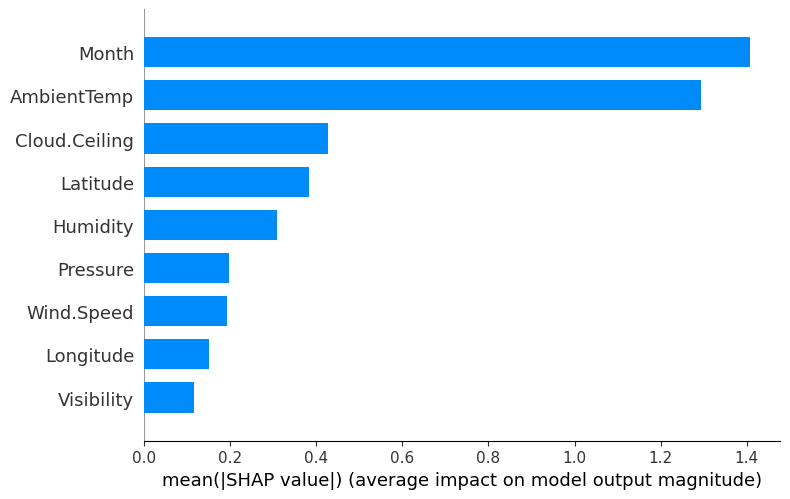

In [39]:
# build shapley value plot to illustrate variables' importance on the output of the model
shap_values = shap.TreeExplainer(regOptimized).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')
plt.show()

## Conclusion

The R^2 score of the improved model terminated at approximately 0.865 (this may vary slightly). The graph of the Shapley values illustrates that the month and the ambient temperature were the most impactful on the model output (meaning they were the best predictors of the power output). Logically, the month variable makes sense that this is the case, as each month has a different amount of sunshine, mainly due to the interplay of climate related factors by season. Ambient temperature would also be reasonable, since the more sunlight there is, the more solar energy the photovoltaic cells can convert to generate electricity. 

While the R^2 score is quite high, there are a few limitations to this model that we want to address. The main limitation is that some of the factors listed here are out of the control of solar electricity producers. For example, months are cyclical, and so there isn't a way to preserve the specific characteristics of the best months in terms of solar panel energy output. Another limitation is the model not being able to predict solar power output of solar panels with improved technology as well as it does current solar panels. This could be addressed by including data about the model of photovoltaic cells in the data, which would require restructuring the model. 